# 0. Importando dependencias necesarias

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from xgboost import XGBClassifier
from xgboost import plot_importance
from lazypredict.Supervised import LazyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
plt.style.use("seaborn-dark")

In [109]:
df_raw = pd.read_csv(r'..\data\raw\weatherAUS.csv')
df = df_raw.copy()

# 1. Primer vistazo a los datos

### 1.1 Lugares distintos

In [110]:
len(df_raw['Location'].unique())

49

### 1.2 Cantidad de datos y columnas

In [111]:
df.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

In [112]:
# Cantidad de observaciones y variables
df.shape

(145460, 23)

### 1.3 Revisando balance de clases

In [113]:
# Revisando si hay desbalance en la variable target
df['RainTomorrow'].value_counts()

No     110316
Yes     31877
Name: RainTomorrow, dtype: int64

# 2. Preprocesamiento de datos

### 2.1 Datos categóricos a datos numéricos

In [114]:
df['RainToday'] = (df['RainToday'] == 'Yes')*1
df['RainTomorrow'] = (df['RainTomorrow'] == 'Yes')*1

In [115]:
replace_values = {'N':0,'NNE':22.5,'NE':45,'ENE':67.5,'E':90,'ESE':112.5,'SE':135,'SSE':157.5,'S':180,'SSW':202.5,'SW':225,'WSW':247.5,'W':270,'WNW':292.5,'NW':315,'NNW':337.5}
df['WindGustDir'] = df['WindGustDir'].map(replace_values)
df['WindDir9am'] = df['WindDir9am'].map(replace_values)
df['WindDir3pm'] = df['WindDir3pm'].map(replace_values)

In [116]:
# Pasando la columna de fechas a datetime y sólo tomando el mes. Se mueve la columna de mes al principio del dataset.
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]

In [117]:
# Haciendo one-hot encoding del mes y renombrando de acuerdo al mes
df = pd.get_dummies(df, columns=['Month'], prefix='Month')
df = df.rename(columns={'Month_1':'Jan','Month_2':'Feb','Month_3':'Mar','Month_4':'Apr','Month_5':'May','Month_6':'Jun','Month_7':'Jul','Month_8':'Aug','Month_9':'Sep','Month_10':'Oct','Month_11':'Nov','Month_12':'Dec'})

### 2.2 Análisis de datos nulos

In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 35 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           145460 non-null  datetime64[ns]
 1   Location       145460 non-null  object        
 2   MinTemp        143975 non-null  float64       
 3   MaxTemp        144199 non-null  float64       
 4   Rainfall       142199 non-null  float64       
 5   Evaporation    82670 non-null   float64       
 6   Sunshine       75625 non-null   float64       
 7   WindGustDir    135134 non-null  float64       
 8   WindGustSpeed  135197 non-null  float64       
 9   WindDir9am     134894 non-null  float64       
 10  WindDir3pm     141232 non-null  float64       
 11  WindSpeed9am   143693 non-null  float64       
 12  WindSpeed3pm   142398 non-null  float64       
 13  Humidity9am    142806 non-null  float64       
 14  Humidity3pm    140953 non-null  float64       
 15  

In [119]:
(df.isnull().sum()*100)/len(df.index)

Date             0.00
Location         0.00
MinTemp          1.02
MaxTemp          0.87
Rainfall         2.24
Evaporation     43.17
Sunshine        48.01
WindGustDir      7.10
WindGustSpeed    7.06
WindDir9am       7.26
WindDir3pm       2.91
WindSpeed9am     1.21
WindSpeed3pm     2.11
Humidity9am      1.82
Humidity3pm      3.10
Pressure9am     10.36
Pressure3pm     10.33
Cloud9am        38.42
Cloud3pm        40.81
Temp9am          1.21
Temp3pm          2.48
RainToday        0.00
RainTomorrow     0.00
Jan              0.00
Feb              0.00
Mar              0.00
Apr              0.00
May              0.00
Jun              0.00
Jul              0.00
Aug              0.00
Sep              0.00
Oct              0.00
Nov              0.00
Dec              0.00
dtype: float64

In [120]:
# Se toman estos features para estudiar los datos faltantes
null = df.loc[:,["Date","Location","Sunshine","Evaporation","Cloud3pm","Cloud9am","Pressure9am","Pressure3pm", "RainToday","RainTomorrow"]].copy()

In [121]:
# Conviertiendo la variable Date a datetime y estableciéndola como indice
null['Date'] = pd.to_datetime(null['Date'])
null = null.set_index('Date')

In [122]:
# Filtrando los datos por mes
null[null.index.month.isin([7])].isnull().sum()*100/len(null[null.index.month.isin([7])])

Location        0.00
Sunshine       46.82
Evaporation    41.16
Cloud3pm       37.10
Cloud9am       36.02
Pressure9am    10.05
Pressure3pm    10.10
RainToday       0.00
RainTomorrow    0.00
dtype: float64

<AxesSubplot:>

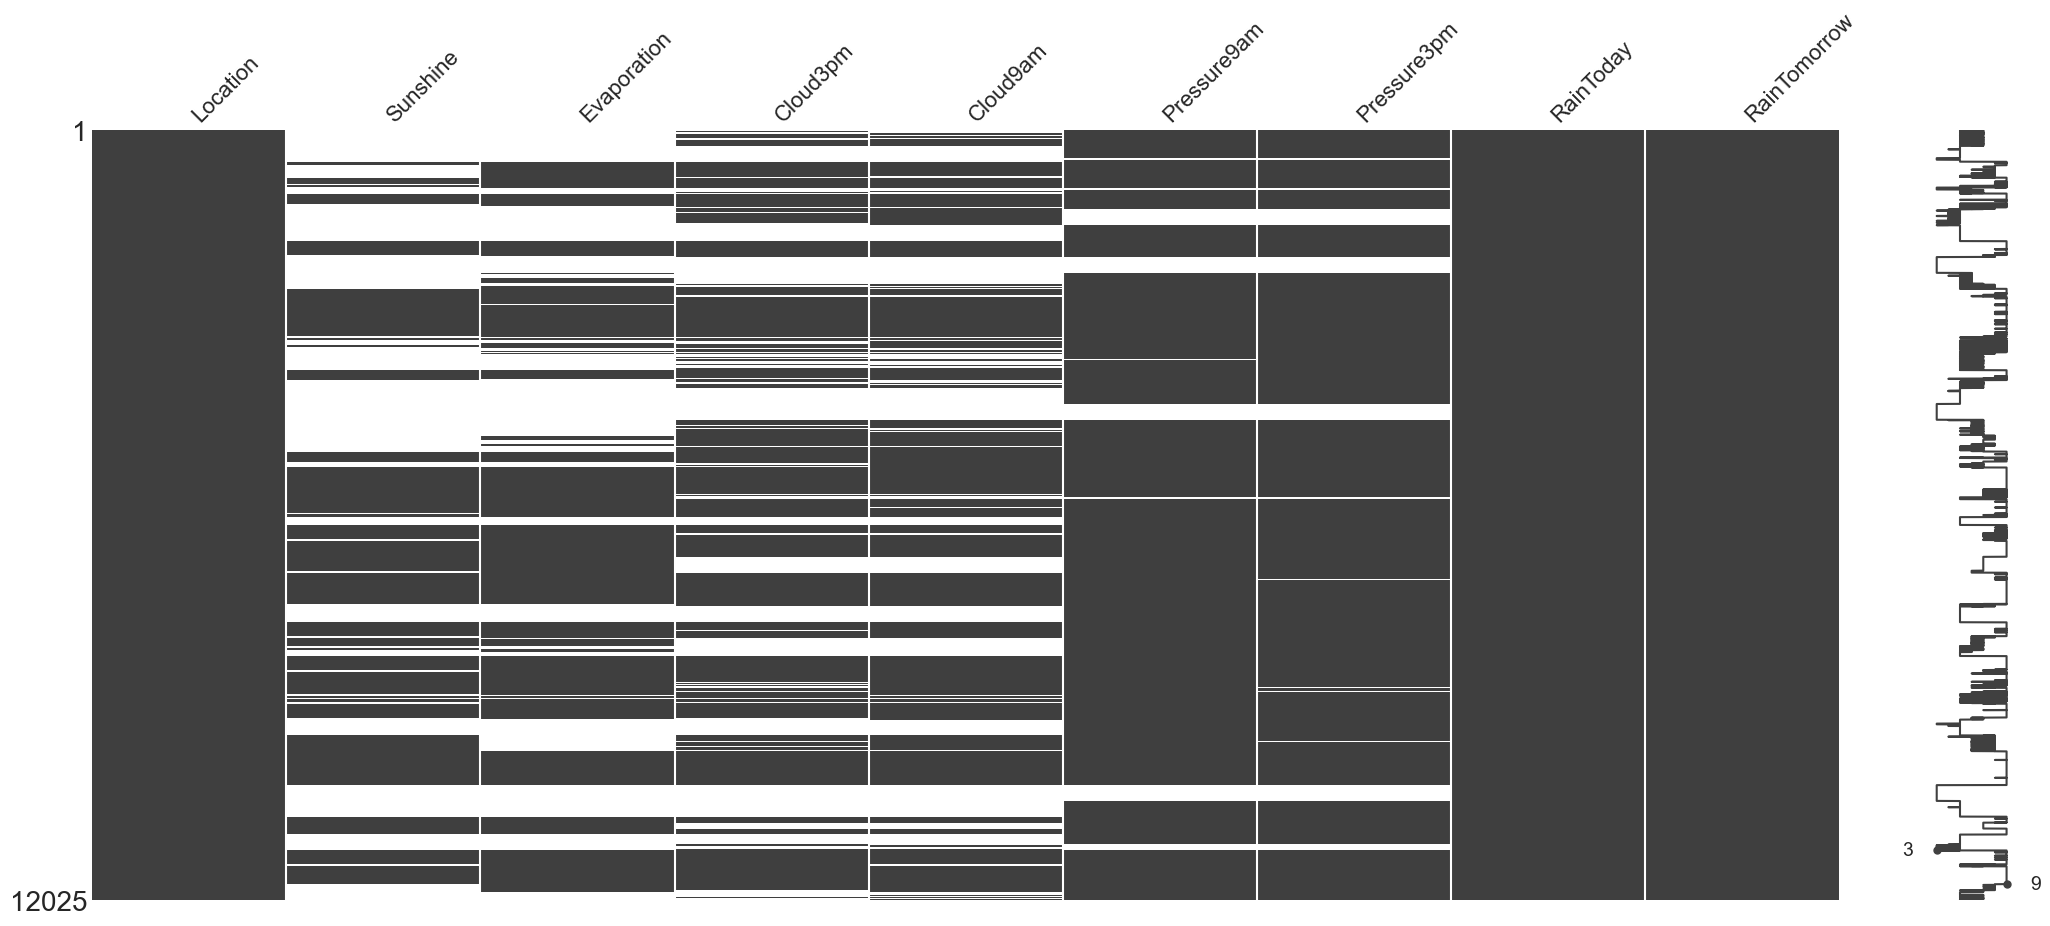

In [123]:
msno.matrix(null[null.index.month.isin([7])])

Los datos se presentan en la gráfica de manera cronológica. Filtrando por mes se ve casi siempre la misma cantidad de datos faltantes, por lo que no hay un patrón aparente. Uno puede meterse más a fondo en el análisis de datos faltantes, pero para el objetivo de este desafío no es necesario.

### 2.3 Correlación de datos

<AxesSubplot:>

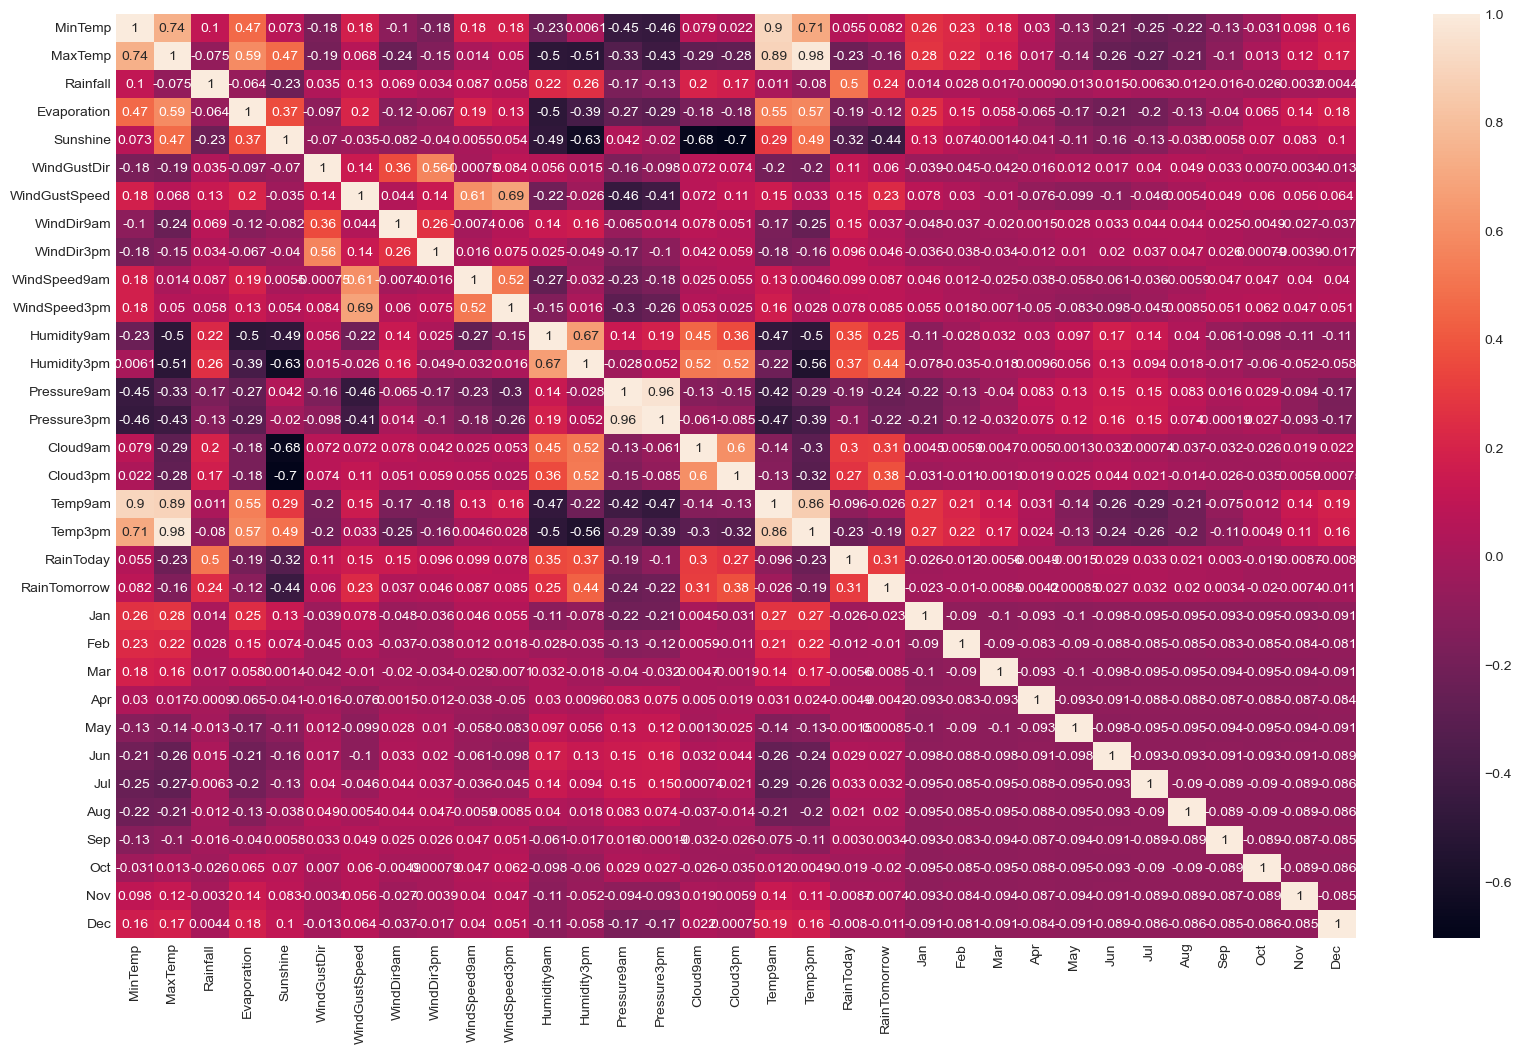

In [124]:
cor_data = df.corr()
plt.figure(figsize=(20,12))
sns.heatmap(cor_data,annot=True)

### 2.4 Eliminando columnas innecesarias

In [125]:
# Eliminando la columna de date y location
df = df.drop(['Date','Location'], axis=1)

### 2.5 Estandarización de datos

In [126]:
# Haciendo standarización de los datos menos RainTomorrow correspondiente a la variable target
scaler = StandardScaler()
df_scaled = df.drop(['RainTomorrow'], axis=1)
df_scaled = pd.DataFrame(scaler.fit_transform(df_scaled), columns=df_scaled.columns)
df_scaled['RainTomorrow'] = df['RainTomorrow']

### 2.6 Copia del dataframe para imputar datos

In [127]:
df_imputed = df_scaled.copy()

In [128]:
# Imputando los datos faltantes con la media en todas las columnas
for col in df_imputed.columns:
    df_imputed[col].fillna(df_imputed[col].mean(), inplace=True)

### 2.7 Determinando feature importance y ver qué modelos son los más adecuados

#### Columnas con datos nulos

Accuracy: 85.84%
F1 Score: 62.61%


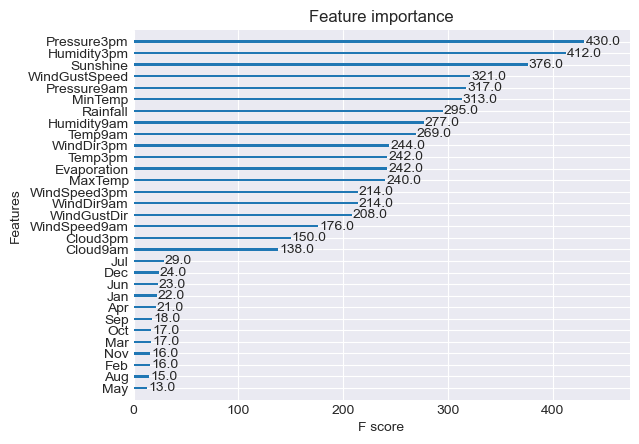

In [129]:
# Tomando las variables independientes y dependientes
X = df_scaled.drop('RainTomorrow', axis=1)
y = df_scaled['RainTomorrow']
# Entrenando el modelo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
model = XGBClassifier()
model.fit(X_train, y_train)
plot_importance(model)
# Haciendo predicciones
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# F1 Score
f1 = f1_score(y_test, y_pred)
print("F1 Score: %.2f%%" % (f1 * 100.0))

In [130]:
# Lazyclassifier
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)
models

  0%|          | 0/29 [00:00<?, ?it/s]

 97%|█████████▋| 28/29 [14:34<01:45, 105.69s/it]

[LightGBM] [Info] Number of positive: 25552, number of negative: 90816
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004136 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2623
[LightGBM] [Info] Number of data points in the train set: 116368, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219579 -> initscore=-1.268120
[LightGBM] [Info] Start training from score -1.268120


100%|██████████| 29/29 [14:34<00:00, 30.16s/it] 


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
QuadraticDiscriminantAnalysis,0.79,0.76,0.76,0.80,0.35
NearestCentroid,0.77,0.75,0.75,0.78,0.20
XGBClassifier,0.86,0.75,0.75,0.85,0.56
LGBMClassifier,0.86,0.74,0.74,0.85,0.68
RandomForestClassifier,0.86,0.73,0.73,0.85,20.16
GaussianNB,0.80,0.73,0.73,0.81,0.24
ExtraTreesClassifier,0.86,0.72,0.72,0.84,15.37
LinearDiscriminantAnalysis,0.84,0.72,0.72,0.83,0.55
AdaBoostClassifier,0.84,0.71,0.71,0.83,6.69


#### Con columnas completas

Accuracy: 85.93%
F1 Score: 62.72%


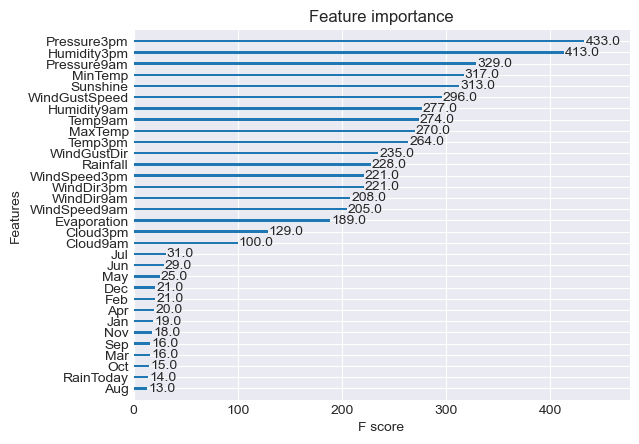

In [131]:
# Tomando las variables independientes y dependientes
X = df_imputed.drop('RainTomorrow', axis=1)
y = df_imputed['RainTomorrow']
# Entrenando el modelo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
model = XGBClassifier()
model.fit(X_train, y_train)
plot_importance(model)
# Haciendo predicciones
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# F1 Score
f1 = f1_score(y_test, y_pred)
print("F1 Score: %.2f%%" % (f1 * 100.0))

In [132]:
# Lazyclassifier
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)
models

 97%|█████████▋| 28/29 [14:16<01:43, 103.81s/it]

[LightGBM] [Info] Number of positive: 25552, number of negative: 90816
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003747 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2625
[LightGBM] [Info] Number of data points in the train set: 116368, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219579 -> initscore=-1.268120
[LightGBM] [Info] Start training from score -1.268120


100%|██████████| 29/29 [14:17<00:00, 29.57s/it] 


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
QuadraticDiscriminantAnalysis,0.78,0.76,0.76,0.80,0.31
NearestCentroid,0.77,0.75,0.75,0.78,0.17
XGBClassifier,0.86,0.75,0.75,0.85,0.48
LGBMClassifier,0.86,0.74,0.74,0.85,0.61
RandomForestClassifier,0.86,0.73,0.73,0.85,19.93
GaussianNB,0.80,0.73,0.73,0.81,0.22
ExtraTreesClassifier,0.86,0.72,0.72,0.84,15.44
LinearDiscriminantAnalysis,0.84,0.72,0.72,0.83,0.53
AdaBoostClassifier,0.84,0.71,0.71,0.83,6.89


### 2.8 Revisando cómo mejora el modelo eliminando columnas que no son importantes

In [143]:
# Obteniendo las mejores variables de acuerdo a plot_importance
best_features = model.get_booster().get_score(importance_type='weight')
best_features = sorted(best_features.items(), key=lambda x: x[1], reverse=True)
best_features = [x[0] for x in best_features]

In [148]:
# Reduciendo el número de variables a las mejores k para ver cómo mejora el desempeño del modelo
for k in range(1, len(best_features)+1):
    X = df_imputed[best_features[:k]]
    y = df_imputed['RainTomorrow']
    # Entrenando el modelo
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
    model_changing_num_variables = XGBClassifier()
    model_changing_num_variables.fit(X_train, y_train)
    # Revisando el desempeño en accuracy y f1 score
    y_pred = model_changing_num_variables.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    f1 = f1_score(y_test, y_pred)
    print("F1 Score: %.2f%%" % (f1 * 100.0), "\n")

Accuracy: 78.48%
F1 Score: 11.33% 

Accuracy: 83.25%
F1 Score: 50.14% 

Accuracy: 83.28%
F1 Score: 51.07% 

Accuracy: 83.86%
F1 Score: 53.39% 

Accuracy: 84.37%
F1 Score: 56.04% 

Accuracy: 84.71%
F1 Score: 57.82% 

Accuracy: 84.83%
F1 Score: 58.33% 

Accuracy: 84.76%
F1 Score: 58.22% 

Accuracy: 85.06%
F1 Score: 59.23% 

Accuracy: 84.94%
F1 Score: 58.97% 

Accuracy: 85.15%
F1 Score: 59.74% 

Accuracy: 85.35%
F1 Score: 60.81% 

Accuracy: 85.52%
F1 Score: 61.26% 

Accuracy: 85.62%
F1 Score: 61.64% 

Accuracy: 85.64%
F1 Score: 61.94% 

Accuracy: 85.65%
F1 Score: 61.82% 

Accuracy: 85.64%
F1 Score: 61.70% 

Accuracy: 85.76%
F1 Score: 62.24% 

Accuracy: 85.77%
F1 Score: 62.14% 

Accuracy: 85.83%
F1 Score: 62.40% 

Accuracy: 85.90%
F1 Score: 62.69% 

Accuracy: 85.78%
F1 Score: 62.12% 

Accuracy: 85.77%
F1 Score: 62.21% 

Accuracy: 85.71%
F1 Score: 61.94% 

Accuracy: 85.78%
F1 Score: 62.44% 

Accuracy: 85.71%
F1 Score: 62.26% 

Accuracy: 85.77%
F1 Score: 62.25% 

Accuracy: 85.75%
F1 Score: 6

Accuracy: 84.90%
F1 Score: 58.61%


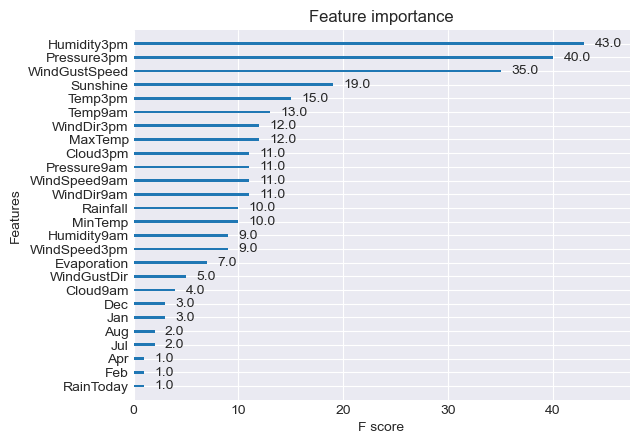

In [149]:
# Tomando las variables independientes y dependientes
X = df_imputed.drop('RainTomorrow', axis=1)
y = df_imputed['RainTomorrow']
# Entrenando el modelo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
model_2 = XGBClassifier(max_depth=2, gamma=0.1, learning_rate=0.1)
model_2.fit(X_train, y_train)
# Haciendo predicciones
y_pred = model_2.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# F1 Score
f1 = f1_score(y_test, y_pred)
print("F1 Score: %.2f%%" % (f1 * 100.0))

In [150]:
import wandb
import random

# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="my-awesome-project",

    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.02,
    "architecture": "CNN",
    "dataset": "CIFAR-100",
    "epochs": 10,
    }
)

# simulate training
epochs = 10
offset = random.random() / 5
for epoch in range(2, epochs):
    acc = 1 - 2 ** -epoch - random.random() / epoch - offset
    loss = 2 ** -epoch + random.random() / epoch + offset

    # log metrics to wandb
    wandb.log({"acc": acc, "loss": loss})

# [optional] finish the wandb run, necessary in notebooks
wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mario-alan-16180 (optimllab). Use `wandb login --relogin` to force relogin


acc,▁▆▆▇▇▇▇█
loss,█▄▄▃▁▁▂▂
acc,0.97081
loss,0.10643
